In [0]:

account   = "weatherdatastorage09"
container = "bronzelayer"
gold_dir  = "goldlayer/weather_features"       

gold_path = f"abfss://{container}@{account}.dfs.core.windows.net/{gold_dir}"

spark.conf.set(
    f"fs.azure.account.key.{account}.dfs.core.windows.net",
    "B2bEeFnUp3PZ3F30/WS4303QZSBtriz3pc4ntFa6cH5kbSALhzmK8YLN1wCUrpTNjGoVSQXNZQH8+ASt+5Nm4w=="  
)


In [0]:

import pandas as pd

gold_pdf = (
    spark.read
         .format("delta")
         .load(gold_path)
         .toPandas()
)

print("Shape before drop-na:", gold_pdf.shape)
gold_pdf.dropna(inplace=True)
print("Shape after  drop-na:", gold_pdf.shape)
gold_pdf.head()


Shape before drop-na: (1629108, 6)
Shape after  drop-na: (1596329, 6)


,datetime,location,temperature,humidity,pressure,wind_speed
0,2015-12-20 13:00:00,Vancouver,280.380000,81.0,1000.0,6.0
1,2015-12-20 14:00:00,Vancouver,277.620000,87.0,1000.0,7.0
2,2015-12-20 15:00:00,Vancouver,277.386887,86.0,1000.0,6.0
3,2015-12-20 16:00:00,Vancouver,276.430000,86.0,1002.0,3.0
4,2015-12-20 17:00:00,Vancouver,276.540000,100.0,997.0,3.0


In [0]:
from sklearn.model_selection import train_test_split

FEATURES = ["humidity", "pressure", "wind_speed"]
TARGET   = "temperature"

X = gold_pdf[FEATURES]
y = gold_pdf[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train rows: {len(X_train)}, Test rows: {len(X_test)}")


Train rows: 1277063, Test rows: 319266


In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)
rmse   = mean_squared_error(y_test, y_pred, squared=False)
print(f"Baseline LinearRegression RMSE: {rmse:.2f}")


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Baseline LinearRegression RMSE: 9.84


In [0]:

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def objective(params):
    if params["max_depth"] is not None:
        params["max_depth"] = int(params["max_depth"])
    params["n_estimators"] = int(params["n_estimators"])

    model = RandomForestRegressor(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse  = mean_squared_error(y_test, preds, squared=False)
    return {"loss": rmse, "status": STATUS_OK}

search_space = {
    "n_estimators": hp.choice("n_estimators", [50, 100, 200, 300]),
    "max_depth":    hp.choice("max_depth",    [5, 10, 15, 20, None]),
}

trials = Trials()
best   = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials,
    rstate=__import__("numpy").random.default_rng(42)  
)

print("Best Hyperopt parameters:", best)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:49<15:39, 49.44s/trial, best loss: 8.711181614321152]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 10%|█         | 2/20 [03:09<30:44, 102.48s/trial, best loss: 8.711181614321152]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 15%|█▌        | 3/20 [03:33<18:56, 66.84s/trial, best loss: 8.711181614321152] 

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 20%|██        | 4/20 [05:41<24:12, 90.80s/trial, best loss: 8.648551067690377]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 25%|██▌       | 5/20 [06:50<20:44, 82.94s/trial, best loss: 8.648551067690377]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading /local_disk0/repl_tmp_data/ReplId-197f7-97e5f-7/tmpbm83o7wh/model/model.pkl:   0%|          | 0.00/1…

 30%|███       | 6/20 [09:26<25:09, 107.83s/trial, best loss: 8.648551067690377]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading /local_disk0/repl_tmp_data/ReplId-197f7-97e5f-7/tmpanp54oo_/model/model.pkl:   0%|          | 0.00/1…

 35%|███▌      | 7/20 [12:02<26:47, 123.63s/trial, best loss: 8.648551067690377]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 40%|████      | 8/20 [12:40<19:17, 96.42s/trial, best loss: 8.648551067690377] 

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [13:26<14:47, 80.64s/trial, best loss: 8.648551067690377]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 50%|█████     | 10/20 [15:43<16:21, 98.18s/trial, best loss: 8.648551067690377]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [16:08<11:19, 75.52s/trial, best loss: 8.648551067690377]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading /local_disk0/repl_tmp_data/ReplId-197f7-97e5f-7/tmpmht8k03a/model/model.pkl:   0%|          | 0.00/1…

 60%|██████    | 12/20 [19:56<16:16, 122.06s/trial, best loss: 8.648551067690377]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [20:52<11:54, 102.04s/trial, best loss: 8.648551067690377]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 70%|███████   | 14/20 [21:56<09:03, 90.56s/trial, best loss: 8.648551067690377] 

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [23:32<07:40, 92.15s/trial, best loss: 8.648551067690377]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 80%|████████  | 16/20 [24:21<05:16, 79.14s/trial, best loss: 8.648551067690377]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading /local_disk0/repl_tmp_data/ReplId-197f7-97e5f-7/tmp8fwzwexn/model/model.pkl:   0%|          | 0.00/1…

 85%|████████▌ | 17/20 [27:03<05:12, 104.07s/trial, best loss: 8.648551067690377]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 90%|█████████ | 18/20 [28:40<03:23, 101.99s/trial, best loss: 8.648551067690377]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 95%|█████████▌| 19/20 [30:59<01:53, 113.14s/trial, best loss: 8.648551067690377]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 20/20 [31:40<00:00, 95.01s/trial, best loss: 8.648551067690377]
Best Hyperopt parameters: {'max_depth': 2, 'n_estimators': 2}


In [0]:
best_params = {
    "n_estimators": [50, 100, 200, 300][best["n_estimators"]],
    "max_depth":    [5, 10, 15, 20, None][best["max_depth"]],
    "random_state": 42,
    "n_jobs":       -1
}

rf = RandomForestRegressor(**best_params)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_pred, squared=False)
print(f"RandomForest RMSE (tuned): {rf_rmse:.2f}")


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

RandomForest RMSE (tuned): 8.65


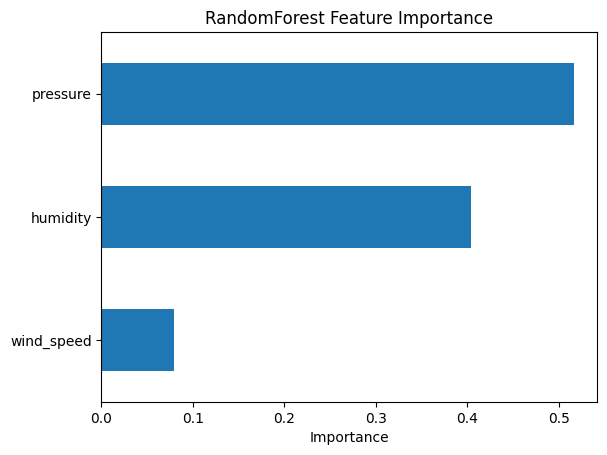

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

imp = pd.Series(rf.feature_importances_, index=FEATURES).sort_values(ascending=False)
imp.plot(kind="barh")
plt.title("RandomForest Feature Importance")
plt.xlabel("Importance")
plt.gca().invert_yaxis()           
plt.show()